In [7]:
# --- 1. Impor Pustaka ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prapemrosesan & Seleksi Fitur
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Model Klasifikasi
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Metrik Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

In [8]:
class DataHandler:
    """Mengelola pemuatan, pembersihan, sampling, dan pemisahan data."""
    def __init__(self, file_path, sample_size=50000, test_size=0.2, random_state=42):
        self.file_path = file_path
        self.sample_size = sample_size
        self.test_size = test_size
        self.random_state = random_state
        self.df = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_and_prepare(self):
        """Memuat data, menghapus duplikat, dan melakukan sampling."""
        print("Tahap 1: Memuat dan melakukan sampling data...")
        self.df = pd.read_csv(self.file_path)
        self.df.drop_duplicates(inplace=True)
        sampled_df = self.df.sample(n=self.sample_size, random_state=self.random_state)
        
        X = sampled_df.drop("Class", axis=1)
        y = sampled_df["Class"]
        
        print(f"   -> Data disampling menjadi {len(sampled_df)} baris.")
        return X, y

    def split_data(self, X, y):
        """Membagi data menjadi set pelatihan dan pengujian."""
        print("Tahap 4: Membagi data menjadi set latih dan uji...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, stratify=y, random_state=self.random_state
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

class FeatureProcessor:
    """Mengelola seleksi fitur dan penskalaan."""
    def __init__(self, variance_threshold=0.01, corr_threshold=0.95):
        self.variance_selector = VarianceThreshold(threshold=variance_threshold)
        self.corr_threshold = corr_threshold
        self.scaler = StandardScaler()
        self.selected_columns = None
        self.columns_to_drop = None

    def select_features(self, X_train, X_test):
        """Melakukan seleksi fitur berdasarkan varians dan korelasi."""
        print("Tahap 2: Melakukan seleksi fitur...")
        # Seleksi Varians
        X_train_var = self.variance_selector.fit_transform(X_train)
        self.selected_columns = X_train.columns[self.variance_selector.get_support()]
        X_train_var_df = pd.DataFrame(X_train_var, columns=self.selected_columns)
        
        # Seleksi Korelasi
        corr_matrix = X_train_var_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.columns_to_drop = [col for col in upper.columns if any(upper[col] > self.corr_threshold)]
        
        X_train_selected = X_train_var_df.drop(columns=self.columns_to_drop)
        X_test_selected = pd.DataFrame(self.variance_selector.transform(X_test), columns=X_train.columns[self.variance_selector.get_support()]).drop(columns=self.columns_to_drop)
        
        print(f"   -> Fitur dipertahankan setelah seleksi: {len(X_train_selected.columns)} dari {len(X_train.columns)}.")
        return X_train_selected, X_test_selected

    def scale_features(self, X_train, X_test):
        """Melakukan penskalaan pada fitur."""
        print("Tahap 3: Melakukan normalisasi fitur (StandardScaler)...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

class ModelTrainer:
    """Mengelola pelatihan dan evaluasi berbagai model klasifikasi."""
    def __init__(self):
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Random Forest": RandomForestClassifier(random_state=42),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            "SVM": SVC(probability=True, random_state=42)
        }
        self.results = {}

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """Melatih semua model dan menyimpan hasilnya."""
        print("\nTahap 5: Melatih dan mengevaluasi semua model...")
        for name, model in self.models.items():
            print(f"   - Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            y_prob = None
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_prob = model.decision_function(X_test)

            self.results[name] = {
                'model': model,
                'y_pred': y_pred,
                'y_prob': y_prob,
                'f1': f1_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'auc': roc_auc_score(y_test, y_prob) if y_prob is not None else 0
            }
        return self.results

class Visualizer:
    """Membuat visualisasi untuk analisis dan perbandingan model."""
    def __init__(self, y_test, results):
        self.y_test = y_test
        self.results = results

    def plot_roc_curves(self):
        """Membuat plot gabungan Kurva ROC untuk semua model."""
        plt.figure(figsize=(12, 9))
        for name, data in self.results.items():
            if data['y_prob'] is not None:
                fpr, tpr, _ = roc_curve(self.y_test, data['y_prob'])
                plt.plot(fpr, tpr, label=f"{name} (AUC = {data['auc']:.4f})", lw=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Tebakan Acak')
        plt.title("Perbandingan Kurva ROC Antar Model", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrices(self):
        """Membuat plot confusion matrix untuk setiap model."""
        num_models = len(self.results)
        fig, axes = plt.subplots((num_models + 1) // 2, 2, figsize=(12, 4 * ((num_models + 1) // 2)))
        axes = axes.flatten()
        
        for i, (name, data) in enumerate(self.results.items()):
            cm = confusion_matrix(self.y_test, data['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f"Confusion Matrix - {name}")
            axes[i].set_xlabel("Prediksi")
            axes[i].set_ylabel("Aktual")
            
        # Sembunyikan sumbu yang tidak digunakan
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.show()

    def plot_metrics_summary(self):
        """Membuat bar plot perbandingan metrik kunci."""
        metrics_data = {
            'Model': list(self.results.keys()),
            'AUC': [res['auc'] for res in self.results.values()],
            'F1-Score': [res['f1'] for res in self.results.values()],
            'Precision': [res['precision'] for res in self.results.values()],
            'Recall': [res['recall'] for res in self.results.values()]
        }
        df_metrics = pd.DataFrame(metrics_data).set_index('Model')
        
        df_metrics.plot(kind='bar', figsize=(15, 8), colormap='viridis', rot=45)
        plt.title('Perbandingan Metrik Kinerja Model', fontsize=16)
        plt.ylabel('Skor', fontsize=12)
        plt.xlabel('Model', fontsize=12)
        plt.legend(title='Metrik')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

Tahap 1: Memuat dan melakukan sampling data...
   -> Data disampling menjadi 50000 baris.
Tahap 4: Membagi data menjadi set latih dan uji...
Tahap 2: Melakukan seleksi fitur...
   -> Fitur dipertahankan setelah seleksi: 30 dari 30.
Tahap 3: Melakukan normalisasi fitur (StandardScaler)...

Tahap 5: Melatih dan mengevaluasi semua model...
   - Training Logistic Regression...
   - Training Decision Tree...
   - Training Random Forest...
   - Training XGBoost...
   - Training SVM...

Tahap 6: Membuat visualisasi perbandingan...


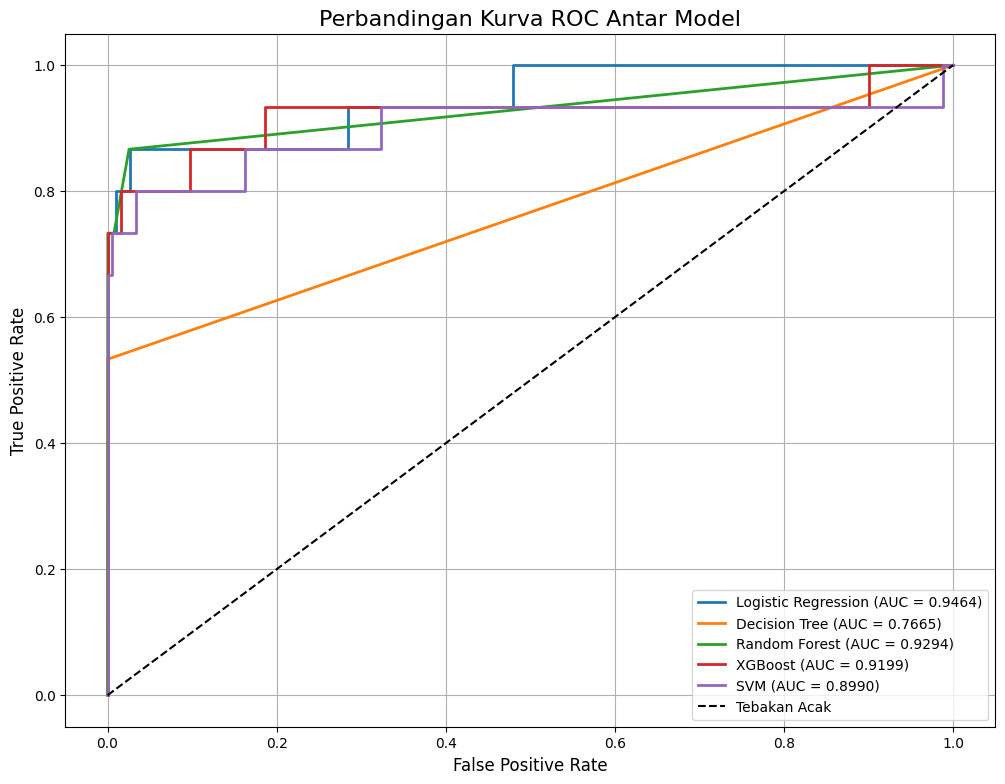

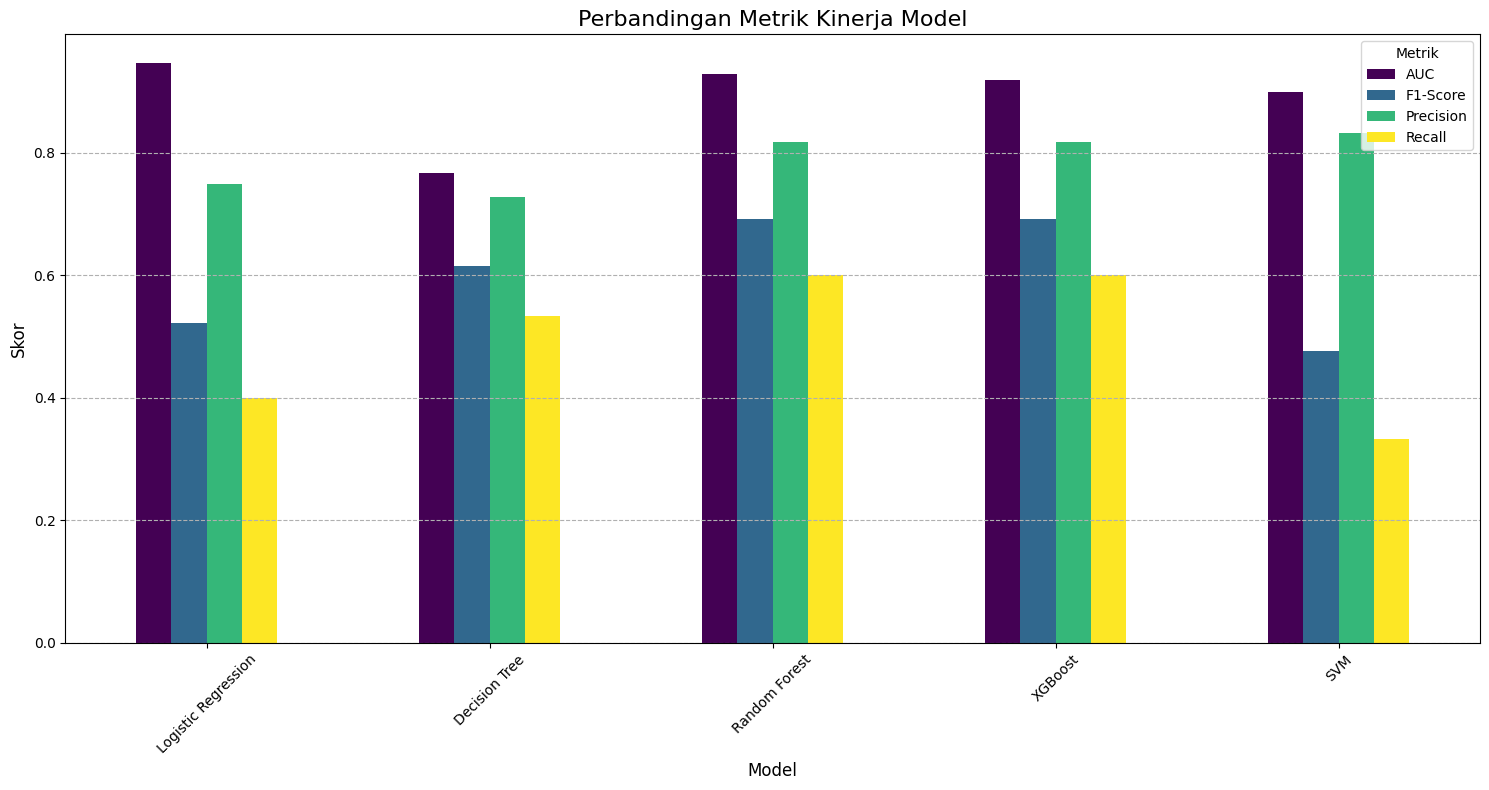

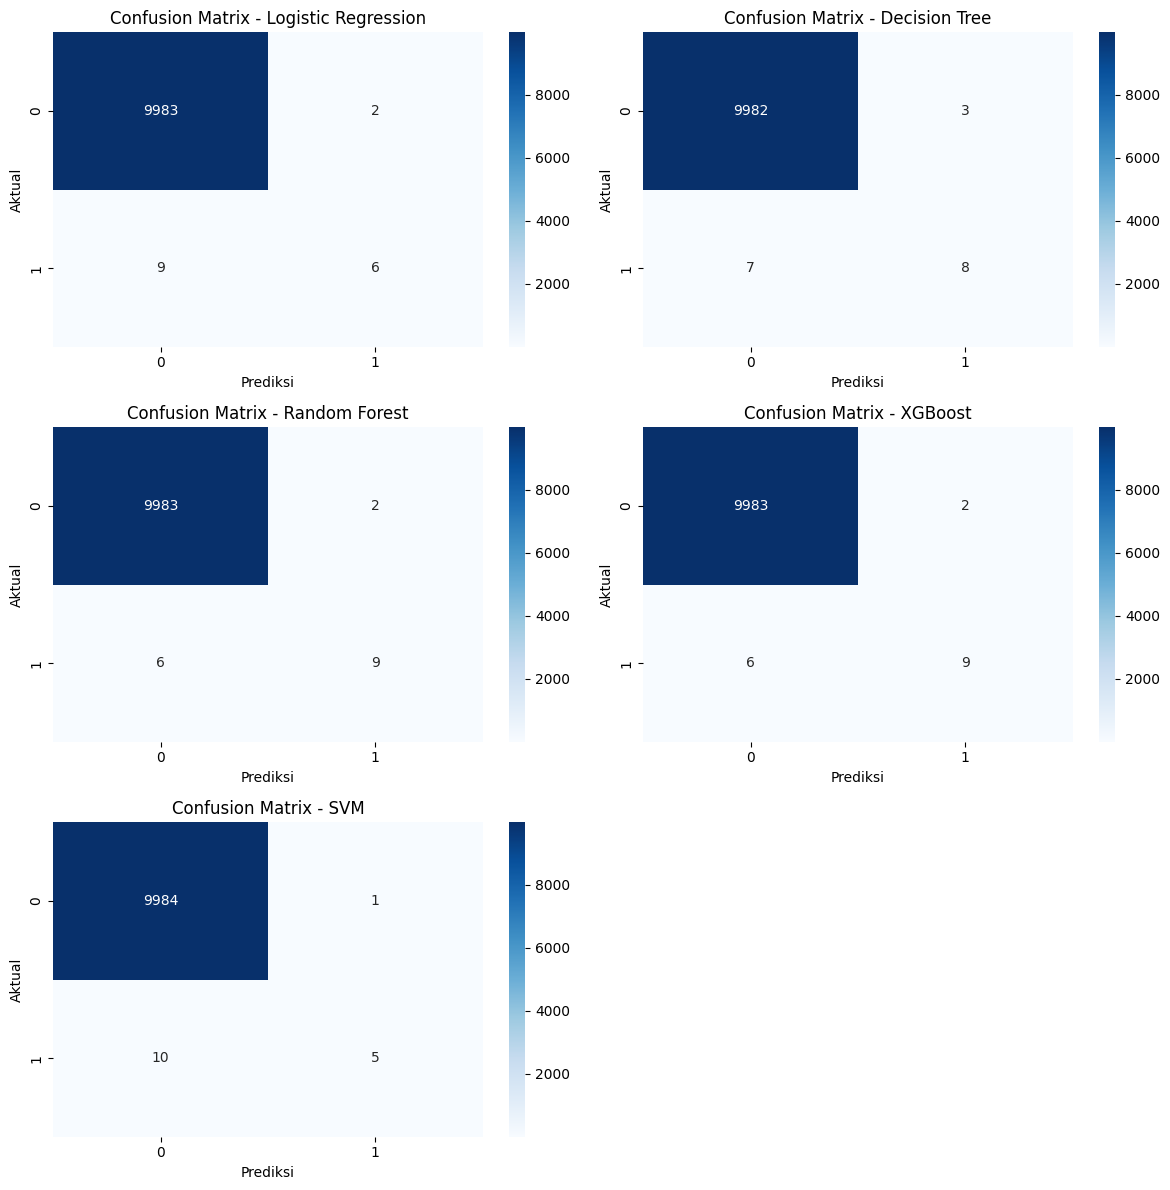


--- Model Terbaik Berdasarkan AUC adalah: Logistic Regression (AUC = 0.9464) ---

Laporan Klasifikasi Detail untuk Model Terbaik:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9985
           1       0.75      0.40      0.52        15

    accuracy                           1.00     10000
   macro avg       0.87      0.70      0.76     10000
weighted avg       1.00      1.00      1.00     10000



In [9]:
# --- Eksekusi Pipeline ---
# 1. Menyiapkan Data
data_handler = DataHandler(file_path='KlasifikasiUTS.csv')
X, y = data_handler.load_and_prepare()

# 2. Seleksi dan Penskalaan Fitur
feature_processor = FeatureProcessor()
X_train_raw, X_test_raw, y_train, y_test = data_handler.split_data(X, y)
X_train_selected, X_test_selected = feature_processor.select_features(X_train_raw, X_test_raw)
X_train_scaled, X_test_scaled = feature_processor.scale_features(X_train_selected, X_test_selected)

# 3. Melatih dan Mengevaluasi Model
model_trainer = ModelTrainer()
results = model_trainer.train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test)

# 4. Membuat Visualisasi
print("\nTahap 6: Membuat visualisasi perbandingan...")
visualizer = Visualizer(y_test, results)
visualizer.plot_roc_curves()
visualizer.plot_metrics_summary()
visualizer.plot_confusion_matrices()

# 5. Menentukan dan Menampilkan Model Terbaik
best_model_name = max(results, key=lambda k: results[k]['auc'])
print(f"\n--- Model Terbaik Berdasarkan AUC adalah: {best_model_name} (AUC = {results[best_model_name]['auc']:.4f}) ---")
print("\nLaporan Klasifikasi Detail untuk Model Terbaik:")
print(classification_report(y_test, results[best_model_name]['y_pred']))